In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
import matplotlib.pyplot as mp
import warnings
from sklearn.metrics import mean_squared_error
#from sklearn.externals import joblib
from sklearn.utils import shuffle
import xgboost as xgb

import pickle
%matplotlib inline

warnings.filterwarnings(action='once')

In [10]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [186]:
# Now we look at the data first--Looking at porfolio which contains the offer data

portfolio.head()
portfolio.shape

portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


#### Analysis:
we can see total of 10 offers are available, with varying degree of difficulty, rewards and duration. These offers are sent to users through a vareity of channels, e.g. email, web, mobile, and social.

In [187]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [188]:
profile.shape

(17000, 5)

#### Analysis:
There are total of 17000 users who will be sent these promotions, this data set consists of member age, the date member became a starbuck rewards program member, their dender, id, and income. However, income and gender data is not compelte (missing values) and will require us to apply NAN fill technique. Date became member on will also be required to put in date formate and separate year, months, and day. We would also need to encode id and simplifiy it. We can also see that there are few 118 years old in our data head. lets also look at the age, gender, and income distribution by lookking at a histogram.


In [189]:
profile['datetime']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['year_of_member'] =  profile['datetime'].dt.year
profile['month_of_member'] =  profile['datetime'].dt.month
profile['day_of_member'] =  profile['datetime'].dt.day
profile['age'] = profile['age'].astype('int')

#Ref" https://stackoverflow.com/questions/27506367/python-pandas-integer-yyyymmdd-to-datetime"
#https://stackoverflow.com/questions/21954197/which-is-the-fastest-way-to-extract-day-month-and-year-from-a-given-date

#### Analysis: 
First we converted the date time column to string and applied date time to convert it into year, month, and day memebr join Starbucks

In [352]:
profile.head()
profile.gender.astype(str)

0        None
1           F
2        None
3           F
4        None
5           M
6        None
7        None
8           M
9        None
10       None
11       None
12          M
13          F
14          M
15          F
16          M
17       None
18          M
19          F
20          F
21          M
22          F
23       None
24          M
25          F
26       None
27          F
28          F
29          M
         ... 
16970       M
16971       F
16972       F
16973       M
16974       F
16975       F
16976       F
16977    None
16978       F
16979       F
16980    None
16981       M
16982    None
16983       F
16984       F
16985       M
16986       F
16987       M
16988       M
16989    None
16990       F
16991    None
16992       F
16993       M
16994    None
16995       F
16996       M
16997       M
16998       F
16999       F
Name: gender, Length: 17000, dtype: object

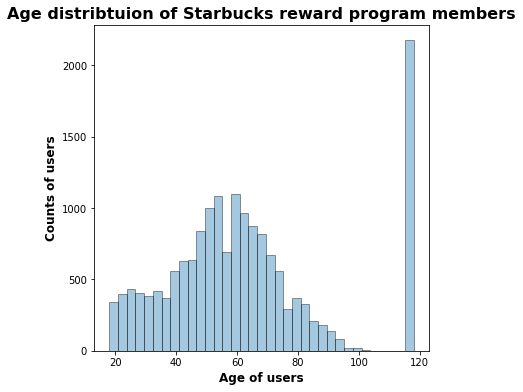

In [191]:
# Age distibution of users--it seems there are quite a few of 118 years old
fig, ax = mp.subplots(figsize=(6,6));
sns.distplot(profile['age'], hist = True, kde = False, bins = 35,
                 hist_kws={'edgecolor':'black'},
                 label = 'Age distribution')
ax.set_title("Age distribtuion of Starbucks reward program members", fontsize=16, weight = 'bold')
ax.set_xlabel("Age of users", fontsize=12, weight = 'bold');
ax.set_ylabel("Counts of users", fontsize=12, weight = 'bold');

#### Analysis: 
Distribution above shows that there is a very high percentage of Starbucks users who are 40 years old or older. 


##### Now we look at the gender distribution in the user data set


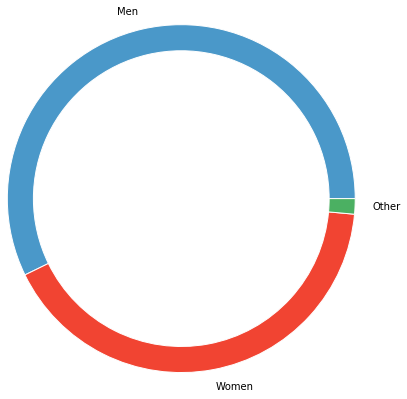

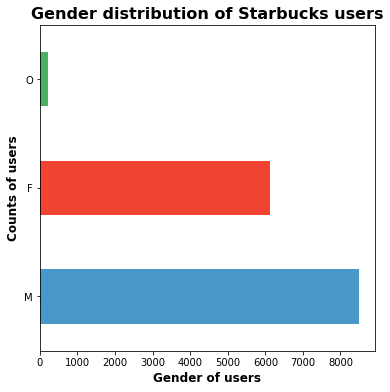

In [192]:
group_names=['Men', 'Women', 'Other']
group_size=profile['gender'].value_counts()

# Create colors
a, b, c=[mp.cm.Blues, mp.cm.Reds, mp.cm.Greens]
 
# First Ring 
fig, ax = mp.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=2.0, labels=group_names, colors=[a(0.6), b(0.6), c(0.6)] )
mp.setp( mypie, width=0.3, edgecolor='white')


fig, ax = mp.subplots(figsize=(6,6));
profile['gender'].value_counts().plot(kind='barh', ax=ax, color=[a(0.6), b(0.6), c(0.6)]);
ax.set_title("Gender distribution of Starbucks users", fontsize=16, weight = 'bold')
ax.set_xlabel("Gender of users", fontsize=12,weight = 'bold');
ax.set_ylabel("Counts of users", fontsize=12,weight = 'bold');

#### Analysis: 
We can see that there are more men inside the user dataset than women. 


##### Now looking at income distribution

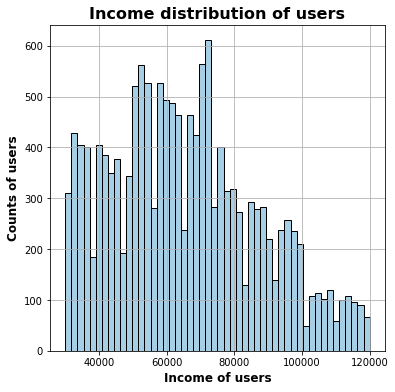

In [193]:
# Original distribution of income---we couldnt use sns as there are NAN values. We would have to first remove NAN values to use sns format. So here we use the matplotlib standard historgram
fig, ax = mp.subplots(figsize=(6,6));
profile['income'].hist(bins=50, ax=ax,  color = a(0.35), edgecolor='black');
ax.set_title("Income distribution of users", fontsize=16, weight = 'bold')
ax.set_xlabel("Income of users", fontsize=12, weight = 'bold');
ax.set_ylabel("Counts of users", fontsize=12, weight = 'bold');

#### Analysis:
We can see from the histogram above that most  users have income less than 80000 per year.

#### As we have seen by glancing at the data, there are quite a few missing values, now we should not check how many are missing in each column of the profile data set. 

In [194]:
profile.isnull().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
datetime            0.000000
year_of_member      0.000000
month_of_member     0.000000
day_of_member       0.000000
dtype: float64

In [195]:
missing = 17000*0.127941
print('gender missing {}' .format(missing))
print('income missing {}'.format(missing))

gender missing 2174.997
income missing 2174.997


#### Analysis:
As we can see that there are missing values of gender and income. There are more than 2000 missing values


##### Now we can take a look at the users for whom gender is missing

In [196]:
profile[profile['gender'].isnull()]

,age,became_member_on,gender,id,income,datetime,year_of_member,month_of_member,day_of_member
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2017,2,12
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2018,7,12
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,2017,8,4
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017-09-25,2017,9,25
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN,2017-10-02,2017,10,2
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN,2016-11-22,2016,11,22
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN,2017-08-24,2017,8,24
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN,2015-09-19,2015,9,19
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN,2017-08-01,2017,8,1
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN,2017-09-07,2017,9,7


#### Analysis:
By looking at the data, we can conclude that for users whose gender is missing, their income data is also missing and they all seem to have an age of 118 years, which is highly unlikely. This seems to suggest that may be 118 is the default age that system puts in when user doesnt fill out the age field while signing up for the rewards program. However system doesnt have any default value for income and gender. We confirmed it by plotting histograms below


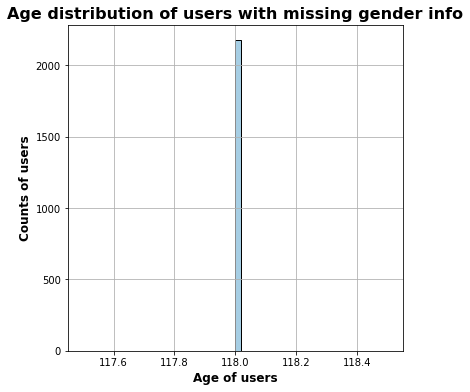

In [197]:
fig, ax = mp.subplots(figsize=(6,6));
profile[profile['gender'].isnull()].age.hist(bins=50, ax=ax,  color = a(0.35), edgecolor='black');
ax.set_title("Age distribution of users with missing gender info", fontsize=16, weight = 'bold')
ax.set_xlabel("Age of users", fontsize=12, weight = 'bold');
ax.set_ylabel("Counts of users", fontsize=12, weight = 'bold');

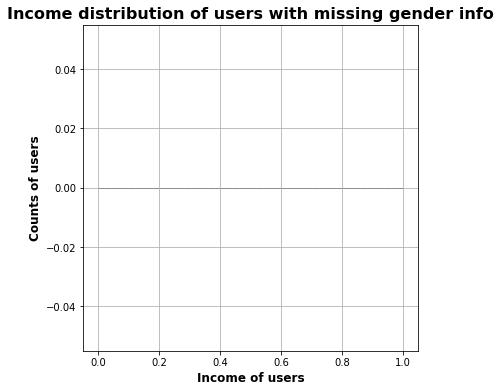

In [198]:
fig, ax = mp.subplots(figsize=(6,6));
profile[profile['gender'].isnull()].income.value_counts().hist(bins=50, ax=ax,  color = a(0.35), edgecolor='black');
ax.set_title("Income distribution of users with missing gender info", fontsize=16, weight = 'bold')
ax.set_xlabel("Income of users", fontsize=12, weight = 'bold');
ax.set_ylabel("Counts of users", fontsize=12, weight = 'bold');

##### Now we look at the transcript data

In [199]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [200]:
transcript.isnull().mean()

event     0.0
person    0.0
time      0.0
value     0.0
dtype: float64

In [201]:
portfolio.isnull().mean()

channels      0.0
difficulty    0.0
duration      0.0
id            0.0
offer_type    0.0
reward        0.0
dtype: float64

#### Analysis:
As can be seen above, that transcript data consist of dicitionary under the column name value, which contains offer_id, offer_id is also available in the portfolio data. We can extract info from this dictionary and merge the table transaction with portfolio. Another thing to be noted here is that, booth transcript and portfolio do not have any missing values, so the missing value processing needs to be only done on the profile data set. First we need to extract the info from dictionary. 



In [11]:
## to extract keys and values from the dictionary, we can use the lambda function as shown in the reference below

#https://stackoverflow.com/questions/46405974/extract-values-from-dictionaries-in-dataframe-columns
    
transcript['type'] = transcript['value'].apply(lambda x : list(x.keys())[0])


transcript['amt'] = transcript['value'].apply(lambda x : list(x.values())[0])    

#after applying these transformation lets look at transcript
transcript.head()

,event,person,time,value,type,amt
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


##### Now we need to encode these ids using the Label encoder

we can set up a function for this as below

In [12]:
def encode (df1, df2, colname1, colname2, colnameout):
    '''
    DESCRIPTION:
    This functions, encode the hash values in the data set and column gives into thier encoded values
    
    INPUTS:
    data frames which has hashvalues
    col names which has hash values
    
    OUTPUTS: 
    encoded values in the new colname that is output
    
    '''
    
    
    encod = LabelEncoder()
    df1[colnameout] = encod.fit_transform(df1[[colname1]])
    df2[colnameout] = encod.transform(df2[[colname2]])
           
    
    return df1, df2, encod

In [13]:
profile, transcript, encod = encode(profile, transcript, "id", "person", 'person_id')

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
transcript.head()
transcript.to_csv("transcript.csv", index = False)

##### Now that we do not need the hashed columns of encoded columns  i.e. id and person in this case, we can drop both of them to make our data look simpler. We can also drop value column from transcript as we have already divided that into type and amt

In [206]:
profile.head()

,age,became_member_on,gender,id,income,datetime,year_of_member,month_of_member,day_of_member,person_id
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,2017,2,12,6961
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,2017,7,15,398
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2018,7,12,3746
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,2017,5,9,7996
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,2017,8,4,10735


In [7]:
profile.drop(['id'], axis=1, inplace=True)
transcript.drop(['person'], axis=1, inplace=True)
profile.head()

,age,became_member_on,gender,income
0,118,20170212,None,NaN
1,55,20170715,F,112000.0
2,118,20180712,None,NaN
3,75,20170509,F,100000.0
4,118,20170804,None,NaN


In [8]:
transcript.drop(['value'], axis=1, inplace=True)
transcript.head()

,event,time,type,amt
0,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


##### Now looking at the data

In [209]:
transcript

,event,time,type,amt,person_id
0,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,7996
1,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,10735
2,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,15043
3,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,9524
4,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,6939
5,offer received,0,offer id,f19421c1d4aa40978ebb69ca19b0e20d,3728
6,offer received,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,13108
7,offer received,0,offer id,3f207df678b143eea3cee63160fa8bed,3059
8,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,11410
9,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,3274


##### We can see that the data consists of both offer data and transactional data. This is given by type column, which is either an amount or offer_id. We can now split this data into two parts, offers data set and amount data set. And we also see that the offer has two indicators offer id and offer_id, so we have to use an OR operator. 

In [9]:
###Transcript data with offers only---| is the OR operator https://stackoverflow.com/questions/5988665/pipe-character-in-python

trans_off = transcript[(transcript['type']=='offer id') | (transcript['type']=='offer_id')]
trans_off.head()
trans_off

,event,time,type,amt
0,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,0,offer id,f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,0,offer id,3f207df678b143eea3cee63160fa8bed
8,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [211]:
##Similarly we can get the transcational data
trans_trans = transcript[(transcript['type']=='amount')]
trans_trans.head()
trans_trans



,event,time,type,amt,person_id
12654,transaction,0,amount,0.83,169
12657,transaction,0,amount,34.56,10701
12659,transaction,0,amount,13.23,5627
12670,transaction,0,amount,19.51,11984
12671,transaction,0,amount,18.97,16908
12678,transaction,0,amount,33.9,6534
12686,transaction,0,amount,0.22,12579
12687,transaction,0,amount,18.59,11364
12691,transaction,0,amount,18.01,6862
12696,transaction,0,amount,19.11,9576


In [212]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


##### Now we run our encoder function defined above on portfolio and trans_off data to get offer ids

In [213]:
portfolio, trans_off, encod = encode(portfolio, trans_off, "id", "amt", 'offer_id')

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [214]:
trans_off.head()

,event,time,type,amt,person_id,offer_id
0,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,7996,6
1,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,10735,0
2,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,15043,2
3,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,9524,9
4,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,6939,4


In [215]:
portfolio.head()


,channels,difficulty,duration,id,offer_type,reward,offer_id
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,4
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,3
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,6
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0


##### Now we can drop hash columns again


In [216]:
portfolio.drop(['id'], axis=1, inplace=True)
trans_off.drop(['amt'], axis=1, inplace=True)
portfolio.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,channels,difficulty,duration,offer_type,reward,offer_id
0,"[email, mobile, social]",10,7,bogo,10,7
1,"[web, email, mobile, social]",10,5,bogo,10,4
2,"[web, email, mobile]",0,4,informational,0,3
3,"[web, email, mobile]",5,7,bogo,5,6
4,"[web, email]",20,10,discount,5,0


In [217]:
trans_off.head()

,event,time,type,person_id,offer_id
0,offer received,0,offer id,7996,6
1,offer received,0,offer id,10735,0
2,offer received,0,offer id,15043,2
3,offer received,0,offer id,9524,9
4,offer received,0,offer id,6939,4


##### Now we want to enocde the channel of offer i.e. email, mobile, web, etc. So we can use for loops and lambada function to achieve that

In [218]:
chan = []
for i in portfolio['channels']:
    for j in i:
        if j not in chan:
            chan.append(j)
            
for j in chan:
    portfolio[j] = portfolio['channels'].apply(lambda x:1 if j in x else 0)
    
 

#we also drop the channels column

portfolio.drop(['channels'], axis = 1, inplace = True)

portfolio.head()


,difficulty,duration,offer_type,reward,offer_id,email,mobile,social,web
0,10,7,bogo,10,7,1,1,1,0
1,10,5,bogo,10,4,1,1,1,1
2,0,4,informational,0,3,1,1,0,1
3,5,7,bogo,5,6,1,1,0,1
4,20,10,discount,5,0,1,0,0,1


In [219]:
portfolio

,difficulty,duration,offer_type,reward,offer_id,email,mobile,social,web
0,10,7,bogo,10,7,1,1,1,0
1,10,5,bogo,10,4,1,1,1,1
2,0,4,informational,0,3,1,1,0,1
3,5,7,bogo,5,6,1,1,0,1
4,20,10,discount,5,0,1,0,0,1
5,7,7,discount,3,1,1,1,1,1
6,10,10,discount,2,9,1,1,1,1
7,0,3,informational,0,5,1,1,1,0
8,5,5,bogo,5,8,1,1,1,1
9,10,7,discount,2,2,1,1,0,1


##### Now we have channels listed, ids encoded and now we can start merging data sets together

In [220]:
#  Now we can merge trans_offer with portfolio and profile

trans_off = pd.merge(trans_off, profile, how = 'left', on = 'person_id')

trans_off = pd.merge(trans_off, portfolio, how = 'left', on = 'offer_id')


trans_off.head()

,event,time,type,person_id,offer_id,age,became_member_on,gender,income,datetime,...,month_of_member,day_of_member,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,...,5,9,5,7,bogo,5,1,1,0,1
1,offer received,0,offer id,10735,0,118,20170804,None,NaN,2017-08-04,...,8,4,20,10,discount,5,1,0,0,1
2,offer received,0,offer id,15043,2,68,20180426,M,70000.0,2018-04-26,...,4,26,10,7,discount,2,1,1,0,1
3,offer received,0,offer id,9524,9,118,20170925,None,NaN,2017-09-25,...,9,25,10,10,discount,2,1,1,1,1
4,offer received,0,offer id,6939,4,118,20171002,None,NaN,2017-10-02,...,10,2,10,5,bogo,10,1,1,1,1


##### The time column in trans_off is the time when the last event occuered, so if the event say offer_recieved, then time column is the time at which it is recieved, and if it says offer completed, then time column says the time at which it was compelted.

###### Now we will basically break down trans_offer into offer_Received, offer_viewed, and offer_completed and get their times. 

In [221]:
trans_off.shape

(134002, 21)

In [222]:
off_rec = trans_off[trans_off['event'] =='offer received']
off_rec.rename(index = str, columns={"time": "time_rec"}, inplace = True)
off_rec.drop(['event'], inplace = True, axis = 1)

##Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
off_rec.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,time_rec,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,difficulty,duration,offer_type,reward,email,mobile,social,web
0,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,5,9,5,7,bogo,5,1,1,0,1
1,0,offer id,10735,0,118,20170804,None,NaN,2017-08-04,2017,8,4,20,10,discount,5,1,0,0,1
2,0,offer id,15043,2,68,20180426,M,70000.0,2018-04-26,2018,4,26,10,7,discount,2,1,1,0,1
3,0,offer id,9524,9,118,20170925,None,NaN,2017-09-25,2017,9,25,10,10,discount,2,1,1,1,1
4,0,offer id,6939,4,118,20171002,None,NaN,2017-10-02,2017,10,2,10,5,bogo,10,1,1,1,1


##### Now we do similar for offer completed, and offer viewed


In [223]:
off_vw = trans_off[trans_off['event'] =='offer viewed']
off_vw.rename(index = str, columns={"time": "time_vw"}, inplace = True)
off_vw.drop(['event'], inplace = True, axis = 1)

##Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
off_vw.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,time_vw,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,difficulty,duration,offer_type,reward,email,mobile,social,web
12650,0,offer id,3728,8,65,20180209,M,53000.0,2018-02-09,2018,2,9,5,5,bogo,5,1,1,1,1
12651,0,offer id,13994,5,53,20170916,O,52000.0,2017-09-16,2017,9,16,0,3,informational,0,1,1,1,0
12652,0,offer id,1051,4,69,20160814,F,57000.0,2016-08-14,2016,8,14,10,5,bogo,10,1,1,1,1
12653,0,offer id,169,7,20,20160711,F,30000.0,2016-07-11,2016,7,11,10,7,bogo,10,1,1,1,0
12654,0,offer id,12743,5,39,20140527,M,51000.0,2014-05-27,2014,5,27,0,3,informational,0,1,1,1,0


In [224]:
off_comp = trans_off[trans_off['event'] =='offer completed']
off_comp.rename(index = str, columns={"time": "time_comp"}, inplace = True)
off_comp.drop(['event'], inplace = True, axis = 1)

##Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
off_comp.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,time_comp,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,difficulty,duration,offer_type,reward,email,mobile,social,web


###### we donot need all the columns in veiwed and completed data set, as we already have that info in offer receievd data set. 

so we will basically drop columns such as  'event', 'age', 'gender', 'income', 'member_year', 'member_month','member_day', 'difficulty', 'duration', 'offer_type', 'reward',  'email', 'mobile', 'social', 'web'

We have to drop these cols otherwise it generates extra duplicate columns which makes it really difficult to navigate the data

In [225]:
drop_cols = ['type', 'gender', 'age', 'became_member_on', 'income', 'datetime', 'year_of_member', 'month_of_member', 'day_of_member', 'difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web']


off_vw.drop(drop_cols, axis =1, inplace = True)

off_vw.head()


C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,time_vw,person_id,offer_id,offer_type
12650,0,3728,8,bogo
12651,0,13994,5,informational
12652,0,1051,4,bogo
12653,0,169,7,bogo
12654,0,12743,5,informational


In [226]:
off_comp.drop(drop_cols, axis = 1, inplace = True)
off_comp.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,time_comp,person_id,offer_id,offer_type


###### Now we merge all the offers to see which users have recived, viewed and completed, or recieved, viewed, and not compelted, recieved not viewed


In [227]:
Offers = pd.merge(off_rec, off_vw, on=['person_id', 'offer_id'], how = 'left')
Offers = pd.merge(Offers, off_comp, on = ['person_id', 'offer_id'], how = 'left')


Offers.shape

(95321, 24)

In [228]:
Offers.head()

,time_rec,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,...,offer_type_x,reward,email,mobile,social,web,time_vw,offer_type_y,time_comp,offer_type
0,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,bogo,5,1,1,0,1,6.0,bogo,NaN,NaN
1,0,offer id,10735,0,118,20170804,None,NaN,2017-08-04,2017,...,discount,5,1,0,0,1,6.0,discount,NaN,NaN
2,0,offer id,10735,0,118,20170804,None,NaN,2017-08-04,2017,...,discount,5,1,0,0,1,624.0,discount,NaN,NaN
3,0,offer id,15043,2,68,20180426,M,70000.0,2018-04-26,2018,...,discount,2,1,1,0,1,18.0,discount,NaN,NaN
4,0,offer id,9524,9,118,20170925,None,NaN,2017-09-25,2017,...,discount,2,1,1,1,1,12.0,discount,NaN,NaN


In [229]:
Offers['time_exp'] = Offers['time_rec'] + Offers['duration']

Offers= Offers[((Offers['time_vw'] >= Offers['time_rec'])&(Offers['time_comp'] >= Offers['time_rec']))\
              |((Offers['time_vw']>= Offers['time_rec'])&(Offers['time_comp'].isnull()))\
              |((Offers['time_vw'].isnull())&(Offers['time_comp'].isnull()))]


Offers.head()

,time_rec,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,...,reward,email,mobile,social,web,time_vw,offer_type_y,time_comp,offer_type,time_exp
0,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,5,1,1,0,1,6.0,bogo,NaN,NaN,7
1,0,offer id,10735,0,118,20170804,None,NaN,2017-08-04,2017,...,5,1,0,0,1,6.0,discount,NaN,NaN,10
2,0,offer id,10735,0,118,20170804,None,NaN,2017-08-04,2017,...,5,1,0,0,1,624.0,discount,NaN,NaN,10
3,0,offer id,15043,2,68,20180426,M,70000.0,2018-04-26,2018,...,2,1,1,0,1,18.0,discount,NaN,NaN,7
4,0,offer id,9524,9,118,20170925,None,NaN,2017-09-25,2017,...,2,1,1,1,1,12.0,discount,NaN,NaN,10


In [230]:
Offers.shape

(84396, 25)

##### Now we can write a function that will tell us if the particualr promo was sucessful or not


In [231]:
def succ_offer(df):
    if ((df['time_rec']<= df['time_vw'])&\
        (df['time_vw']<= df['time_comp'])&\
        (df['time_comp']<=df['time_exp'])):
        return 1
    else:
        return 0
    
    
def trid_offer(df):
    if ((df['time_rec']<= df['time_vw'])&\
       (df['time_vw']<= df['time_exp'])&\
       (math.isnan(df['time_comp']))|\
       (df['time_rec']<= df['time_vw'])&\
       (df['time_exp']<df['time_comp'])&\
       (df['time_vw']<=df['time_exp'])):
        return  1
    else:
        return 0
    
    
def failed_offer(df):
    if((df['Success']==1)|(df['tried']==1)):
        return 0
    else:
        return 1


In [232]:
Offers['Success'] = Offers.apply(succ_offer, axis = 1)
Offers['tried'] = Offers.apply(trid_offer, axis = 1)
Offers['failed']= Offers.apply(failed_offer, axis =1)

##### Now we also want to check if the same users are recieving the same offer more than once at the same time, i.e. same unit of time


In [233]:
off_rec[off_rec.duplicated(subset=['time_rec', 'person_id', 'offer_id'])]


,time_rec,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,difficulty,duration,offer_type,reward,email,mobile,social,web


###### There are no duplicates here

In [234]:
Offers[Offers.duplicated(subset=['time_rec', 'person_id', 'offer_id'])]

,time_rec,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,...,social,web,time_vw,offer_type_y,time_comp,offer_type,time_exp,Success,tried,failed
2,0,offer id,10735,0,118,20170804,None,NaN,2017-08-04,2017,...,0,1,624.0,discount,NaN,NaN,10,0,0,1
5,0,offer id,9524,9,118,20170925,None,NaN,2017-09-25,2017,...,1,1,522.0,discount,NaN,NaN,10,0,0,1
8,0,offer id,3728,8,65,20180209,M,53000.0,2018-02-09,2018,...,1,1,504.0,bogo,NaN,NaN,5,0,0,1
10,0,offer id,13108,1,118,20170824,None,NaN,2017-08-24,2017,...,1,1,348.0,discount,NaN,NaN,7,0,0,1
17,0,offer id,4996,7,64,20170909,M,100000.0,2017-09-09,2017,...,1,0,510.0,bogo,NaN,NaN,7,0,0,1
19,0,offer id,12984,3,78,20170616,F,71000.0,2017-06-16,2017,...,0,1,348.0,informational,NaN,NaN,4,0,0,1
21,0,offer id,14192,0,88,20170518,F,53000.0,2017-05-18,2017,...,0,1,690.0,discount,NaN,NaN,10,0,0,1
23,0,offer id,16458,9,42,20130811,M,69000.0,2013-08-11,2013,...,1,1,408.0,discount,NaN,NaN,10,0,0,1
25,0,offer id,13880,0,56,20180428,F,88000.0,2018-04-28,2018,...,0,1,360.0,discount,NaN,NaN,10,0,0,1
48,0,offer id,3340,6,73,20171212,M,38000.0,2017-12-12,2017,...,0,1,360.0,bogo,NaN,NaN,7,0,0,1


In [235]:
Offers.drop_duplicates(subset=['time_rec', 'person_id', 'offer_id'], keep = 'first', inplace = True)

In [236]:
Offers.shape

(74933, 28)

In [237]:
off_rec.shape

(76277, 20)

In [238]:
Offers[Offers.duplicated(subset=['time_rec', 'person_id', 'offer_id'])]

,time_rec,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,...,social,web,time_vw,offer_type_y,time_comp,offer_type,time_exp,Success,tried,failed


In [239]:
rec_trid_suc = Offers[(Offers['Success']==1)|(Offers['tried']==1)]
rec_trid_suc.head()

,time_rec,type,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,...,social,web,time_vw,offer_type_y,time_comp,offer_type,time_exp,Success,tried,failed
0,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,0,1,6.0,bogo,NaN,NaN,7,0,1,0
1,0,offer id,10735,0,118,20170804,None,NaN,2017-08-04,2017,...,0,1,6.0,discount,NaN,NaN,10,0,1,0
7,0,offer id,3728,8,65,20180209,M,53000.0,2018-02-09,2018,...,1,1,0.0,bogo,NaN,NaN,5,0,1,0
31,0,offer id,1051,4,69,20160814,F,57000.0,2016-08-14,2016,...,1,1,0.0,bogo,NaN,NaN,5,0,1,0
36,0,offer id,169,7,20,20160711,F,30000.0,2016-07-11,2016,...,1,0,0.0,bogo,NaN,NaN,7,0,1,0


In [240]:
rec_trid_suc = pd.merge(rec_trid_suc, trans_trans, on = 'person_id', how = 'left')

rec_trid_suc['time_trans'] = rec_trid_suc['time']


In [241]:
rec_trid_suc.drop(['time'], axis = 1, inplace = True)

In [242]:
rec_trid_suc.head()

,time_rec,type_x,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,...,time_comp,offer_type,time_exp,Success,tried,failed,event,type_y,amt,time_trans
0,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,NaN,7,0,1,0,transaction,amount,19.89,132.0
1,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,NaN,7,0,1,0,transaction,amount,17.78,144.0
2,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,NaN,7,0,1,0,transaction,amount,19.67,222.0
3,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,NaN,7,0,1,0,transaction,amount,29.72,240.0
4,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,NaN,7,0,1,0,transaction,amount,23.93,378.0


In [243]:
def transaction(df):
    if df['Success'] ==1:
        if((df['time_trans']>=df['time_rec'])and(df['time_trans']<=df['time_comp'])):
            return 1
        else:
            return 0
    else:
        if ((df['time_trans'] >=df['time_rec'])and(df['time_trans'])<=df['time_exp']):
            return 1
        else:
            return 0


In [244]:
rec_trid_suc['trans_offer'] = rec_trid_suc.apply(transaction, axis =1)

In [245]:
rec_trid_suc.head()

,time_rec,type_x,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,...,offer_type,time_exp,Success,tried,failed,event,type_y,amt,time_trans,trans_offer
0,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,7,0,1,0,transaction,amount,19.89,132.0,0
1,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,7,0,1,0,transaction,amount,17.78,144.0,0
2,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,7,0,1,0,transaction,amount,19.67,222.0,0
3,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,7,0,1,0,transaction,amount,29.72,240.0,0
4,0,offer id,7996,6,75,20170509,F,100000.0,2017-05-09,2017,...,NaN,7,0,1,0,transaction,amount,23.93,378.0,0


In [246]:
rec_trid_suc_suc = rec_trid_suc[rec_trid_suc['trans_offer']==1]

rec_trid_suc_suc.head()

,time_rec,type_x,person_id,offer_id,age,became_member_on,gender,income,datetime,year_of_member,...,offer_type,time_exp,Success,tried,failed,event,type_y,amt,time_trans,trans_offer
27,0,offer id,169,7,20,20160711,F,30000.0,2016-07-11,2016,...,NaN,7,0,1,0,transaction,amount,0.83,0.0,1
28,0,offer id,169,7,20,20160711,F,30000.0,2016-07-11,2016,...,NaN,7,0,1,0,transaction,amount,1.44,6.0,1
55,0,offer id,6862,7,37,20170515,M,92000.0,2017-05-15,2017,...,NaN,7,0,1,0,transaction,amount,18.01,0.0,1
63,0,offer id,10701,2,42,20160117,M,96000.0,2016-01-17,2016,...,NaN,7,0,1,0,transaction,amount,34.56,0.0,1
182,0,offer id,15772,2,118,20180405,None,NaN,2018-04-05,2018,...,NaN,7,0,1,0,transaction,amount,1.16,0.0,1


##### Now we should find the number of offers compelted by each users, how much money was spent, number of transactions, and average spending by each user

In [247]:
rec_trid_suc_suc_distinct = rec_trid_suc_suc.drop_duplicates(['time_rec', 'offer_id', 'person_id'])


rec_trid_suc_suc_count = rec_trid_suc_suc_distinct.groupby(['person_id', 'offer_id']).agg({'Success':'sum', 'tried':'sum'}).reset_index()

In [248]:
rec_trid_suc_suc_count.rename(index = str, columns = {'Success':'n_success', 'tried':'n_tried'}, inplace = True)

rec_trid_suc_suc_count.head()

,person_id,offer_id,n_success,n_tried
0,9,7,0,1
1,18,8,0,1
2,34,4,0,1
3,38,3,0,1
4,39,1,0,1


In [249]:
rec_trid_suc_suc_mon = rec_trid_suc_suc.groupby(['person_id', 'offer_id']).agg({'amt':'sum', 'trans_offer':'count'}).reset_index()

In [250]:
rec_trid_suc_suc_mon['avg_spent_offer'] = rec_trid_suc_suc_mon['amt']/rec_trid_suc_suc_mon['trans_offer']

rec_trid_suc_suc_mon.head()

,person_id,offer_id,trans_offer,amt,avg_spent_offer
0,9,7,1,9.03,9.03
1,18,8,1,27.32,27.32
2,34,4,1,16.72,16.72
3,38,3,1,23.07,23.07
4,39,1,1,8.91,8.91


In [251]:
rec_trid_suc_suc_count = pd.merge(rec_trid_suc_suc_count, rec_trid_suc_suc_mon, on= ['person_id', 'offer_id'], how = 'left', validate = 'one_to_one')

rec_trid_suc_suc_count.head()

,person_id,offer_id,n_success,n_tried,trans_offer,amt,avg_spent_offer
0,9,7,0,1,1,9.03,9.03
1,18,8,0,1,1,27.32,27.32
2,34,4,0,1,1,16.72,16.72
3,38,3,0,1,1,23.07,23.07
4,39,1,0,1,1,8.91,8.91


In [252]:
off_summ = off_rec.groupby(['person_id', 'offer_id']).agg({'time_rec':'count'}).reset_index()
off_summ.rename(index = str, columns = {'time_rec':'n_offers'}, inplace= True)

off_summ.head()


,person_id,offer_id,n_offers
0,0,2,1
1,0,3,1
2,0,5,1
3,0,8,1
4,0,9,1


In [253]:
off_summ = pd.merge(off_summ,rec_trid_suc_suc_count, on = ['person_id', 'offer_id'], how = 'left' )

off_summ.head()

,person_id,offer_id,n_offers,n_success,n_tried,trans_offer,amt,avg_spent_offer
0,0,2,1,NaN,NaN,NaN,NaN,NaN
1,0,3,1,NaN,NaN,NaN,NaN,NaN
2,0,5,1,NaN,NaN,NaN,NaN,NaN
3,0,8,1,NaN,NaN,NaN,NaN,NaN
4,0,9,1,NaN,NaN,NaN,NaN,NaN


In [254]:
off_summ.isnull().mean()

person_id          0.000000
offer_id           0.000000
n_offers           0.000000
n_success          0.948805
n_tried            0.948805
trans_offer        0.948805
amt                0.948805
avg_spent_offer    0.948805
dtype: float64

##### So we need to use .fillna that we learnt during the progran to fill null values

In [255]:
off_summ.fillna(0, inplace = True)

off_summ.head()

,person_id,offer_id,n_offers,n_success,n_tried,trans_offer,amt,avg_spent_offer
0,0,2,1,0.0,0.0,0.0,0.0,0.0
1,0,3,1,0.0,0.0,0.0,0.0,0.0
2,0,5,1,0.0,0.0,0.0,0.0,0.0
3,0,8,1,0.0,0.0,0.0,0.0,0.0
4,0,9,1,0.0,0.0,0.0,0.0,0.0


In [256]:
no_offer_trans = rec_trid_suc_suc[['time_trans', 'person_id', 'amt', 'trans_offer']]
trans_trans.rename(index = str, columns={"time": "time_trans"}, inplace = True)
no_offer_trans.head()


trans_label = pd.merge(trans_trans, no_offer_trans, on = ['time_trans', 'person_id', 'amt'], how = 'left')

trans_label.isnull().mean()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


event          0.000000
time_trans     0.000000
type           0.000000
amt            0.000000
person_id      0.000000
trans_offer    0.974992
dtype: float64

In [257]:
trans_label.fillna(0, inplace = True)

trans_label.isnull().mean()

trans_label.head()

,event,time_trans,type,amt,person_id,trans_offer
0,transaction,0,amount,0.83,169,1.0
1,transaction,0,amount,34.56,10701,1.0
2,transaction,0,amount,13.23,5627,0.0
3,transaction,0,amount,19.51,11984,0.0
4,transaction,0,amount,18.97,16908,1.0


In [258]:
non_offer_trans = trans_label[trans_label['trans_offer'] ==0]
non_offer_trans.head()

,event,time_trans,type,amt,person_id,trans_offer
2,transaction,0,amount,13.23,5627,0.0
3,transaction,0,amount,19.51,11984,0.0
6,transaction,0,amount,0.22,12579,0.0
7,transaction,0,amount,18.59,11364,0.0
10,transaction,0,amount,36.19,5109,0.0


In [259]:
non_offer_trans_summ = non_offer_trans.groupby('person_id').agg({'amt':'sum', 'trans_offer':'count'}).reset_index()


non_offer_trans_summ.rename(index = str, columns={'amt':'non_offer_spent', 'trans_offer':'non_offer_trans_count'}, inplace = True)

non_offer_trans_summ['avg_no_offer_spent'] = non_offer_trans_summ['non_offer_spent']/non_offer_trans_summ['non_offer_trans_count']


non_offer_trans_summ.head()

,person_id,non_offer_trans_count,non_offer_spent,avg_no_offer_spent
0,0,8,127.60,15.950000
1,1,3,4.09,1.363333
2,2,5,79.46,15.892000
3,3,8,196.86,24.607500
4,4,12,154.05,12.837500


##### Now we track for each offer how many of this type were recieved, successful, tried, transaction made

In [260]:
def offer_summary(df, n):
    df2 = df[df['offer_id']== n]
    return df2


In [261]:
off_summ_0 = offer_summary(off_summ,   0)
off_summ_1 = offer_summary(off_summ,   1)
off_summ_2 = offer_summary(off_summ,   2)
off_summ_3 = offer_summary(off_summ,   3)
off_summ_4 = offer_summary(off_summ,   4)
off_summ_5 = offer_summary(off_summ,   5)
off_summ_6 = offer_summary(off_summ,   6)
off_summ_7 = offer_summary(off_summ,   7)
off_summ_8 = offer_summary(off_summ,   8)
off_summ_9 = offer_summary(off_summ,   9)



In [262]:
def rename_col(df, n):
    df.rename(columns = lambda x: x+n , inplace = True)
    return df

In [263]:
off_summ_0 =rename_col(off_summ_0, '_0')
off_summ_0.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,person_id_0,offer_id_0,n_offers_0,n_success_0,n_tried_0,trans_offer_0,amt_0,avg_spent_offer_0
6,2,0,1,0.0,0.0,0.0,0.0,0.0
19,5,0,1,0.0,0.0,0.0,0.0,0.0
23,6,0,1,0.0,0.0,0.0,0.0,0.0
36,10,0,1,0.0,0.0,0.0,0.0,0.0
40,11,0,1,0.0,0.0,0.0,0.0,0.0


In [264]:
off_summ_1 =rename_col(off_summ_1, '_1')
off_summ_2 =rename_col(off_summ_2, '_2')
off_summ_3 =rename_col(off_summ_3, '_3')
off_summ_4 =rename_col(off_summ_4, '_4')
off_summ_5 =rename_col(off_summ_5, '_5')
off_summ_6 =rename_col(off_summ_6, '_6')
off_summ_7 =rename_col(off_summ_7, '_7')
off_summ_8 =rename_col(off_summ_8, '_8')
off_summ_9 =rename_col(off_summ_9, '_9')

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [316]:
off_summ_0.rename(index = str, columns ={'person_id_0':'person_id'}, inplace = True)
off_summ_1.rename(index = str, columns ={'person_id_1':'person_id'}, inplace = True)
off_summ_2.rename(index = str, columns ={'person_id_2':'person_id'}, inplace = True)
off_summ_3.rename(index = str, columns ={'person_id_3':'person_id'}, inplace = True)
off_summ_4.rename(index = str, columns ={'person_id_4':'person_id'}, inplace = True)
off_summ_5.rename(index = str, columns ={'person_id_5':'person_id'}, inplace = True)
off_summ_6.rename(index = str, columns ={'person_id_6':'person_id'}, inplace = True)
off_summ_7.rename(index = str, columns ={'person_id_7':'person_id'}, inplace = True)
off_summ_8.rename(index = str, columns ={'person_id_8':'person_id'}, inplace = True)
off_summ_9.rename(index = str, columns ={'person_id_9':'person_id'}, inplace = True)
off_summ_9.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,person_id,offer_id_9,n_offers_9,n_success_9,n_tried_9,trans_offer_9,amt_9,avg_spent_offer_9
4,0,9,1,0.0,0.0,0.0,0.0,0.0
14,3,9,2,0.0,0.0,0.0,0.0,0.0
22,5,9,2,0.0,0.0,0.0,0.0,0.0
26,6,9,1,0.0,0.0,0.0,0.0,0.0
29,7,9,1,0.0,0.0,0.0,0.0,0.0


In [317]:
all_offer_profile = pd.merge(profile, off_summ_0, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_1, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_2, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_3, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_4, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_5, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_6, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_7, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_8, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, off_summ_9, on = ['person_id'], how = 'left')
all_offer_profile = pd.merge(all_offer_profile, non_offer_trans_summ, on = ['person_id'], how = 'left')

In [318]:
all_offer_profile.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,offer_id_9,n_offers_9,n_success_9,n_tried_9,trans_offer_9,amt_9,avg_spent_offer_9,non_offer_trans_count,non_offer_spent,avg_no_offer_spent
0,118,20170212,None,NaN,2017-02-12,2017,2,12,6961,0.0,...,9.0,2.0,0.0,1.0,1.0,0.74,0.74,7.0,14.62,2.088571
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,77.01,25.670000
2,118,20180712,None,NaN,2018-07-12,2018,7,12,3746,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,14.30,2.383333
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,159.27,22.752857
4,118,20170804,None,NaN,2017-08-04,2017,8,4,10735,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.65,1.550000


In [319]:
all_offer_profile.isnull().mean()

age                      0.000000
became_member_on         0.000000
gender                   0.127941
income                   0.127941
datetime                 0.000000
year_of_member           0.000000
month_of_member          0.000000
day_of_member            0.000000
person_id                0.000000
offer_id_0               0.625059
n_offers_0               0.625059
n_success_0              0.625059
n_tried_0                0.625059
trans_offer_0            0.625059
amt_0                    0.625059
avg_spent_offer_0        0.625059
offer_id_1               0.627941
n_offers_1               0.627941
n_success_1              0.627941
n_tried_1                0.627941
trans_offer_1            0.627941
amt_1                    0.627941
avg_spent_offer_1        0.627941
offer_id_2               0.630294
n_offers_2               0.630294
n_success_2              0.630294
n_tried_2                0.630294
trans_offer_2            0.630294
amt_2                    0.630294
avg_spent_offe

In [320]:
#all_offer_profile.fillna(0.0, inplace = True)

In [321]:
all_offer_profile.isnull().mean()

age                      0.000000
became_member_on         0.000000
gender                   0.127941
income                   0.127941
datetime                 0.000000
year_of_member           0.000000
month_of_member          0.000000
day_of_member            0.000000
person_id                0.000000
offer_id_0               0.625059
n_offers_0               0.625059
n_success_0              0.625059
n_tried_0                0.625059
trans_offer_0            0.625059
amt_0                    0.625059
avg_spent_offer_0        0.625059
offer_id_1               0.627941
n_offers_1               0.627941
n_success_1              0.627941
n_tried_1                0.627941
trans_offer_1            0.627941
amt_1                    0.627941
avg_spent_offer_1        0.627941
offer_id_2               0.630294
n_offers_2               0.630294
n_success_2              0.630294
n_tried_2                0.630294
trans_offer_2            0.630294
amt_2                    0.630294
avg_spent_offe

In [322]:
all_offer_profile.loc[:, 'datetime':'avg_no_offer_spent'] =all_offer_profile.loc[:, 'datetime':'avg_no_offer_spent'].fillna(0)


#ref: https://stackoverflow.com/questions/36556256/how-do-i-fill-na-values-in-multiple-columns-in-pandas/36556382#36556382

In [323]:
all_offer_profile.isnull().mean()

age                      0.000000
became_member_on         0.000000
gender                   0.127941
income                   0.127941
datetime                 0.000000
year_of_member           0.000000
month_of_member          0.000000
day_of_member            0.000000
person_id                0.000000
offer_id_0               0.000000
n_offers_0               0.000000
n_success_0              0.000000
n_tried_0                0.000000
trans_offer_0            0.000000
amt_0                    0.000000
avg_spent_offer_0        0.000000
offer_id_1               0.000000
n_offers_1               0.000000
n_success_1              0.000000
n_tried_1                0.000000
trans_offer_1            0.000000
amt_1                    0.000000
avg_spent_offer_1        0.000000
offer_id_2               0.000000
n_offers_2               0.000000
n_success_2              0.000000
n_tried_2                0.000000
trans_offer_2            0.000000
amt_2                    0.000000
avg_spent_offe

In [324]:
all_offer_profile.head()

all_offer_profile.shape

(17000, 82)

In [325]:
def addition(df, colnamenew, colname0, colname1, colname2, colname3, colname4, colname5, colname6, colname7, colname8, colname9, colname10):
    df[[colnamenew]] = df[[colname0]]+df[[colname1]]+df[[colname2]]+df[[colname3]]+df[[colname4]]+df[[colname5]]+df[[colname6]]+df[[colname7]]+df[[colname8]]+df[[colname9]]+df[[colname10]]
    return df

In [326]:
all_offer_profile['amt_total'] = all_offer_profile['amt_0'] + all_offer_profile['amt_1'] + all_offer_profile['amt_2'] + all_offer_profile['amt_3'] + all_offer_profile['amt_4'] +all_offer_profile['amt_5'] + all_offer_profile['amt_6'] + all_offer_profile['amt_7'] + all_offer_profile['amt_8'] + all_offer_profile['amt_9'] + all_offer_profile['non_offer_spent'] 

all_offer_profile['total_trans'] =  all_offer_profile['trans_offer_0']+ all_offer_profile['trans_offer_1']+ all_offer_profile['trans_offer_2']+ all_offer_profile['trans_offer_3']+ all_offer_profile['trans_offer_4']+ all_offer_profile['trans_offer_5']+ all_offer_profile['trans_offer_6']+ all_offer_profile['trans_offer_7']+ all_offer_profile['trans_offer_8']+ all_offer_profile['trans_offer_9']+all_offer_profile['non_offer_trans_count']

all_offer_profile['total_offers'] =  all_offer_profile['n_offers_0']+ all_offer_profile['n_offers_1']+ all_offer_profile['n_offers_2']+ all_offer_profile['n_offers_3']+ all_offer_profile['n_offers_4']+ all_offer_profile['n_offers_5']+ all_offer_profile['n_offers_6']+ all_offer_profile['n_offers_7']+ all_offer_profile['n_offers_8']+ all_offer_profile['n_offers_9']

all_offer_profile['total_success'] =  all_offer_profile['n_success_0']+ all_offer_profile['n_success_1']+ all_offer_profile['n_success_2']+ all_offer_profile['n_success_3']+ all_offer_profile['n_success_4']+ all_offer_profile['n_success_5']+ all_offer_profile['n_success_6']+ all_offer_profile['n_success_7']+ all_offer_profile['n_success_8']+ all_offer_profile['n_success_9']

all_offer_profile['total_tried'] =  all_offer_profile['n_tried_0']+ all_offer_profile['n_tried_1']+ all_offer_profile['n_tried_2']+ all_offer_profile['n_tried_3']+ all_offer_profile['n_tried_4']+ all_offer_profile['n_tried_5']+ all_offer_profile['n_tried_6']+ all_offer_profile['n_tried_7']+ all_offer_profile['n_tried_8']+ all_offer_profile['n_tried_9']



In [327]:
all_offer_profile['avg_per_trans']  = all_offer_profile['amt_total']/all_offer_profile['total_trans']




all_offer_profile.loc[:, 'datetime':'avg_per_trans'] =all_offer_profile.loc[:, 'datetime':'avg_per_trans'].fillna(0)
all_offer_profile.isnull().mean()

age                      0.000000
became_member_on         0.000000
gender                   0.127941
income                   0.127941
datetime                 0.000000
year_of_member           0.000000
month_of_member          0.000000
day_of_member            0.000000
person_id                0.000000
offer_id_0               0.000000
n_offers_0               0.000000
n_success_0              0.000000
n_tried_0                0.000000
trans_offer_0            0.000000
amt_0                    0.000000
avg_spent_offer_0        0.000000
offer_id_1               0.000000
n_offers_1               0.000000
n_success_1              0.000000
n_tried_1                0.000000
trans_offer_1            0.000000
amt_1                    0.000000
avg_spent_offer_1        0.000000
offer_id_2               0.000000
n_offers_2               0.000000
n_success_2              0.000000
n_tried_2                0.000000
trans_offer_2            0.000000
amt_2                    0.000000
avg_spent_offe

In [328]:
portfolio

,difficulty,duration,offer_type,reward,offer_id,email,mobile,social,web
0,10,7,bogo,10,7,1,1,1,0
1,10,5,bogo,10,4,1,1,1,1
2,0,4,informational,0,3,1,1,0,1
3,5,7,bogo,5,6,1,1,0,1
4,20,10,discount,5,0,1,0,0,1
5,7,7,discount,3,1,1,1,1,1
6,10,10,discount,2,9,1,1,1,1
7,0,3,informational,0,5,1,1,1,0
8,5,5,bogo,5,8,1,1,1,1
9,10,7,discount,2,2,1,1,0,1


##### Now we can see that offer_ids are associated with the type of offer, so we can get some statistics for each type of offer such as number of trans, number successful, number tried, avg spent etc.

bogo= 7,4, 6, 8
discount = 0,1,9,2
informational = 5,3

In [329]:
all_offer_profile['bogo_n_offers'] =  all_offer_profile['n_offers_7']+ all_offer_profile['n_offers_4']+ all_offer_profile['n_offers_6']+ all_offer_profile['n_offers_8']
all_offer_profile['discount_n_offers'] =  all_offer_profile['n_offers_0']+ all_offer_profile['n_offers_1']+ all_offer_profile['n_offers_9']+ all_offer_profile['n_offers_2']
all_offer_profile['info_n_offers'] =  all_offer_profile['n_offers_5']+ all_offer_profile['n_offers_3']
all_offer_profile['bogo_n_trans'] =  all_offer_profile['trans_offer_7']+ all_offer_profile['trans_offer_4']+ all_offer_profile['trans_offer_6']+ all_offer_profile['trans_offer_8']
all_offer_profile['discount_n_trans'] =  all_offer_profile['trans_offer_0']+ all_offer_profile['trans_offer_1']+ all_offer_profile['trans_offer_9']+ all_offer_profile['trans_offer_2']
all_offer_profile['info_n_trans'] =  all_offer_profile['trans_offer_5']+ all_offer_profile['trans_offer_3']

all_offer_profile['bogo_n_success'] =  all_offer_profile['n_success_7']+ all_offer_profile['n_success_4']+ all_offer_profile['n_success_6']+ all_offer_profile['n_success_8']
all_offer_profile['bogo_n_tried'] =  all_offer_profile['n_tried_7']+ all_offer_profile['n_tried_4']+ all_offer_profile['n_tried_6']+ all_offer_profile['n_tried_8']
all_offer_profile['discount_n_success'] =  all_offer_profile['n_success_0']+ all_offer_profile['n_success_1']+ all_offer_profile['n_success_2'] + all_offer_profile['n_success_9']
all_offer_profile['discount_n_tried'] =  all_offer_profile['n_tried_0']+ all_offer_profile['n_tried_1']+ all_offer_profile['n_tried_2'] + all_offer_profile['n_success_9']
all_offer_profile['info_n_success'] =  all_offer_profile['n_success_5']+ all_offer_profile['n_success_3']
all_offer_profile['info_n_tried'] =  all_offer_profile['n_tried_5']+ all_offer_profile['n_tried_3']



all_offer_profile['bogo_total'] = all_offer_profile['amt_7'] + all_offer_profile['amt_6'] + all_offer_profile['amt_6'] + all_offer_profile['amt_8'] 
all_offer_profile['discount_total'] = all_offer_profile['amt_0'] + all_offer_profile['amt_1'] + all_offer_profile['amt_2'] + all_offer_profile['amt_9'] 
all_offer_profile['info_total'] =  all_offer_profile['amt_5'] + all_offer_profile['amt_3'] 


all_offer_profile['bogo_avg_offer'] = all_offer_profile['bogo_total']/all_offer_profile['bogo_n_offers'] 
all_offer_profile['bogo_avg_trans'] = all_offer_profile['bogo_total']/all_offer_profile['bogo_n_trans'] 
all_offer_profile['discount_avg_offer'] = all_offer_profile['discount_total']/all_offer_profile['discount_n_offers'] 
all_offer_profile['discount_avg_trans'] = all_offer_profile['discount_total']/all_offer_profile['discount_n_trans'] 
all_offer_profile['info_avg_offer'] = all_offer_profile['info_total']/all_offer_profile['info_n_offers'] 
all_offer_profile['info_avg_trans'] = all_offer_profile['info_total']/all_offer_profile['info_n_trans'] 


In [330]:
all_offer_profile.loc[:, 'datetime':'info_avg_trans'] =all_offer_profile.loc[:, 'datetime':'info_avg_trans'].fillna(0)
all_offer_profile.isnull().mean()

age                      0.000000
became_member_on         0.000000
gender                   0.127941
income                   0.127941
datetime                 0.000000
year_of_member           0.000000
month_of_member          0.000000
day_of_member            0.000000
person_id                0.000000
offer_id_0               0.000000
n_offers_0               0.000000
n_success_0              0.000000
n_tried_0                0.000000
trans_offer_0            0.000000
amt_0                    0.000000
avg_spent_offer_0        0.000000
offer_id_1               0.000000
n_offers_1               0.000000
n_success_1              0.000000
n_tried_1                0.000000
trans_offer_1            0.000000
amt_1                    0.000000
avg_spent_offer_1        0.000000
offer_id_2               0.000000
n_offers_2               0.000000
n_success_2              0.000000
n_tried_2                0.000000
trans_offer_2            0.000000
amt_2                    0.000000
avg_spent_offe

###### Now we can get fractions of each transaction type w.r.t to totals


In [331]:
all_offer_profile['frac_amt_0'] =  all_offer_profile['amt_0']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_1'] =  all_offer_profile['amt_1']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_2'] =  all_offer_profile['amt_2']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_3'] =  all_offer_profile['amt_3']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_4'] =  all_offer_profile['amt_4']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_5'] =  all_offer_profile['amt_5']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_6'] =  all_offer_profile['amt_6']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_7'] =  all_offer_profile['amt_7']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_8'] =  all_offer_profile['amt_8']/all_offer_profile['amt_total']
all_offer_profile['frac_amt_9'] =  all_offer_profile['amt_9']/all_offer_profile['amt_total']


all_offer_profile['frac_n_offer_0'] =  all_offer_profile['n_offers_0']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_1'] =  all_offer_profile['n_offers_1']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_2'] =  all_offer_profile['n_offers_2']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_3'] =  all_offer_profile['n_offers_3']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_4'] =  all_offer_profile['n_offers_4']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_5'] =  all_offer_profile['n_offers_5']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_6'] =  all_offer_profile['n_offers_6']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_7'] =  all_offer_profile['n_offers_7']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_8'] =  all_offer_profile['n_offers_8']/all_offer_profile['total_offers']
all_offer_profile['frac_n_offer_9'] =  all_offer_profile['n_offers_9']/all_offer_profile['total_offers']

all_offer_profile['frac_n_trans_0'] =  all_offer_profile['trans_offer_0']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_1'] =  all_offer_profile['trans_offer_1']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_2'] =  all_offer_profile['trans_offer_2']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_3'] =  all_offer_profile['trans_offer_3']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_4'] =  all_offer_profile['trans_offer_4']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_5'] =  all_offer_profile['trans_offer_5']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_6'] =  all_offer_profile['trans_offer_6']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_7'] =  all_offer_profile['trans_offer_7']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_8'] =  all_offer_profile['trans_offer_8']/all_offer_profile['total_trans']
all_offer_profile['frac_n_trans_9'] =  all_offer_profile['trans_offer_9']/all_offer_profile['total_trans']




all_offer_profile['frac_bogo'] =  all_offer_profile['bogo_total']/all_offer_profile['amt_total']
all_offer_profile['frac_disocunt'] =  all_offer_profile['discount_total']/all_offer_profile['amt_total']
all_offer_profile['frac_info'] =  all_offer_profile['info_total']/all_offer_profile['amt_total']

all_offer_profile['frac_bogo_n_offer']=  all_offer_profile['bogo_n_offers']/all_offer_profile['total_offers']
all_offer_profile['frac_discount_n_offer']=  all_offer_profile['discount_n_offers']/all_offer_profile['total_offers']
all_offer_profile['frac_info_n_offer']=  all_offer_profile['info_n_offers']/all_offer_profile['total_offers']


all_offer_profile['frac_bogo_n_trans']=  all_offer_profile['bogo_n_trans']/all_offer_profile['total_trans']
all_offer_profile['frac_discount_n_trans']=  all_offer_profile['discount_n_trans']/all_offer_profile['total_trans']
all_offer_profile['frac_info_n_trans']=  all_offer_profile['info_n_trans']/all_offer_profile['total_trans']


all_offer_profile.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_n_trans_9,frac_bogo,frac_disocunt,frac_info,frac_bogo_n_offer,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans
0,118,20170212,None,NaN,2017-02-12,2017,2,12,6961,0.0,...,0.111111,0.0,0.283333,0.0,0.00,1.0,0.00,0.0,0.222222,0.0
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398,0.0,...,0.000000,0.0,0.000000,0.0,0.50,0.0,0.50,0.0,0.000000,0.0
2,118,20180712,None,NaN,2018-07-12,2018,7,12,3746,0.0,...,0.000000,0.0,0.000000,0.0,0.50,0.0,0.50,0.0,0.000000,0.0
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996,0.0,...,0.000000,0.0,0.000000,0.0,0.75,0.0,0.25,0.0,0.000000,0.0
4,118,20170804,None,NaN,2017-08-04,2017,8,4,10735,0.0,...,0.000000,0.0,0.000000,0.0,0.00,0.6,0.40,0.0,0.000000,0.0


In [332]:
all_offer_profile.isnull().mean()

age                      0.000000
became_member_on         0.000000
gender                   0.127941
income                   0.127941
datetime                 0.000000
year_of_member           0.000000
month_of_member          0.000000
day_of_member            0.000000
person_id                0.000000
offer_id_0               0.000000
n_offers_0               0.000000
n_success_0              0.000000
n_tried_0                0.000000
trans_offer_0            0.000000
amt_0                    0.000000
avg_spent_offer_0        0.000000
offer_id_1               0.000000
n_offers_1               0.000000
n_success_1              0.000000
n_tried_1                0.000000
trans_offer_1            0.000000
amt_1                    0.000000
avg_spent_offer_1        0.000000
offer_id_2               0.000000
n_offers_2               0.000000
n_success_2              0.000000
n_tried_2                0.000000
trans_offer_2            0.000000
amt_2                    0.000000
avg_spent_offe

In [333]:
all_offer_profile.loc[:, 'datetime':'frac_info_n_trans'] =all_offer_profile.loc[:, 'datetime':'frac_info_n_trans'].fillna(0)
all_offer_profile.isnull().mean()

age                      0.000000
became_member_on         0.000000
gender                   0.127941
income                   0.127941
datetime                 0.000000
year_of_member           0.000000
month_of_member          0.000000
day_of_member            0.000000
person_id                0.000000
offer_id_0               0.000000
n_offers_0               0.000000
n_success_0              0.000000
n_tried_0                0.000000
trans_offer_0            0.000000
amt_0                    0.000000
avg_spent_offer_0        0.000000
offer_id_1               0.000000
n_offers_1               0.000000
n_success_1              0.000000
n_tried_1                0.000000
trans_offer_1            0.000000
amt_1                    0.000000
avg_spent_offer_1        0.000000
offer_id_2               0.000000
n_offers_2               0.000000
n_success_2              0.000000
n_tried_2                0.000000
trans_offer_2            0.000000
amt_2                    0.000000
avg_spent_offe

In [334]:
all_offer_profile.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_n_trans_9,frac_bogo,frac_disocunt,frac_info,frac_bogo_n_offer,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans
0,118,20170212,None,NaN,2017-02-12,2017,2,12,6961,0.0,...,0.111111,0.0,0.283333,0.0,0.00,1.0,0.00,0.0,0.222222,0.0
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398,0.0,...,0.000000,0.0,0.000000,0.0,0.50,0.0,0.50,0.0,0.000000,0.0
2,118,20180712,None,NaN,2018-07-12,2018,7,12,3746,0.0,...,0.000000,0.0,0.000000,0.0,0.50,0.0,0.50,0.0,0.000000,0.0
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996,0.0,...,0.000000,0.0,0.000000,0.0,0.75,0.0,0.25,0.0,0.000000,0.0
4,118,20170804,None,NaN,2017-08-04,2017,8,4,10735,0.0,...,0.000000,0.0,0.000000,0.0,0.00,0.6,0.40,0.0,0.000000,0.0


In [361]:
all_offer_profile['gender'] = all_offer_profile['gender'].apply(lambda x:str(x))

In [362]:
### Now we encode gender

genc = ['gender']

for i in gen:
    all_offer_profile2 = pd.concat([all_offer_profile, pd.get_dummies(all_offer_profile[i],prefix=i, prefix_sep='_',\
                                                                      drop_first=False)], axis=1)

In [568]:
gencod = LabelEncoder()
all_offer_profile2['gen_enc'] = gencod.fit_transform(all_offer_profile2['gender'])




In [569]:

all_offer_profile2.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
0,118,20170212,None,NaN,2017-02-12,2017,2,12,6961,0.0,...,1.0,0.00,0.0,0.222222,0.0,0,0,1,0,2
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398,0.0,...,0.0,0.50,0.0,0.000000,0.0,1,0,0,0,0
2,118,20180712,None,NaN,2018-07-12,2018,7,12,3746,0.0,...,0.0,0.50,0.0,0.000000,0.0,0,0,1,0,2
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996,0.0,...,0.0,0.25,0.0,0.000000,0.0,1,0,0,0,0
4,118,20170804,None,NaN,2017-08-04,2017,8,4,10735,0.0,...,0.6,0.40,0.0,0.000000,0.0,0,0,1,0,2


In [365]:
all_offer_profile2.to_csv("all_offer_profile2.csv", index = False)

In [366]:
all_profile = pd.read_csv("all_offer_profile2.csv")

In [376]:
all_profile.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
0,118,20170212,None,NaN,2017-02-12,2017,2,12,6961,0.0,...,1.0,0.00,0.0,0.222222,0.0,0,0,1,0,2
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398,0.0,...,0.0,0.50,0.0,0.000000,0.0,1,0,0,0,0
2,118,20180712,None,NaN,2018-07-12,2018,7,12,3746,0.0,...,0.0,0.50,0.0,0.000000,0.0,0,0,1,0,2
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996,0.0,...,0.0,0.25,0.0,0.000000,0.0,1,0,0,0,0
4,118,20170804,None,NaN,2017-08-04,2017,8,4,10735,0.0,...,0.6,0.40,0.0,0.000000,0.0,0,0,1,0,2


### Now we can divide the data into two where we know the gender and where we do not know the gender. Then we will train and test our model on hte known gender data and then rpedict the genders for unkonw

In [378]:
gen_model =all_profile[all_profile['gender'] !='None']
gen_model.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398,0.0,...,0.000000,0.500000,0.0,0.0,0.0,1,0,0,0,0
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996,0.0,...,0.000000,0.250000,0.0,0.0,0.0,1,0,0,0,0
5,68,20180426,M,70000.0,2018-04-26,2018,4,26,15043,0.0,...,0.500000,0.250000,0.0,0.0,0.0,0,1,0,0,1
8,65,20180209,M,53000.0,2018-02-09,2018,2,9,3728,0.0,...,0.333333,0.000000,0.0,0.0,0.0,0,1,0,0,1
12,58,20171111,M,51000.0,2017-11-11,2017,11,11,3059,0.0,...,0.666667,0.333333,0.0,0.0,0.0,0,1,0,0,1


In [379]:
gen_predict = all_profile[all_profile['gender']=='None']

gen_predict.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
0,118,20170212,None,NaN,2017-02-12,2017,2,12,6961,0.0,...,1.0,0.0,0.0,0.222222,0.0,0,0,1,0,2
2,118,20180712,None,NaN,2018-07-12,2018,7,12,3746,0.0,...,0.0,0.5,0.0,0.000000,0.0,0,0,1,0,2
4,118,20170804,None,NaN,2017-08-04,2017,8,4,10735,0.0,...,0.6,0.4,0.0,0.000000,0.0,0,0,1,0,2
6,118,20170925,None,NaN,2017-09-25,2017,9,25,9524,0.0,...,0.6,0.2,0.0,0.000000,0.0,0,0,1,0,2
7,118,20171002,None,NaN,2017-10-02,2017,10,2,6939,0.0,...,0.4,0.0,0.0,0.000000,0.0,0,0,1,0,2


,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398,0.0,...,0.000000,0.500000,0.0,0.0,0.0,1,0,0,0,0
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996,0.0,...,0.000000,0.250000,0.0,0.0,0.0,1,0,0,0,0
5,68,20180426,M,70000.0,2018-04-26,2018,4,26,15043,0.0,...,0.500000,0.250000,0.0,0.0,0.0,0,1,0,0,1
8,65,20180209,M,53000.0,2018-02-09,2018,2,9,3728,0.0,...,0.333333,0.000000,0.0,0.0,0.0,0,1,0,0,1
12,58,20171111,M,51000.0,2017-11-11,2017,11,11,3059,0.0,...,0.666667,0.333333,0.0,0.0,0.0,0,1,0,0,1


,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
0,118,20170212,None,NaN,2017-02-12,2017,2,12,6961,0.0,...,1.0,0.0,0.0,0.222222,0.0,0,0,1,0,2
2,118,20180712,None,NaN,2018-07-12,2018,7,12,3746,0.0,...,0.0,0.5,0.0,0.000000,0.0,0,0,1,0,2
4,118,20170804,None,NaN,2017-08-04,2017,8,4,10735,0.0,...,0.6,0.4,0.0,0.000000,0.0,0,0,1,0,2
6,118,20170925,None,NaN,2017-09-25,2017,9,25,9524,0.0,...,0.6,0.2,0.0,0.000000,0.0,0,0,1,0,2
7,118,20171002,None,NaN,2017-10-02,2017,10,2,6939,0.0,...,0.4,0.0,0.0,0.000000,0.0,0,0,1,0,2


### Now we do the test train split

In [391]:
train, test = train_test_split(gen_model, test_size = 0.3, random_state = 42)

In [392]:
train.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
9646,67,20171211,F,76000.0,2017-12-11,2017,12,11,16007,0.0,...,0.666667,0.000000,0.0,0.0000,0.0,1,0,0,0,0
14547,42,20171031,M,62000.0,2017-10-31,2017,10,31,9634,0.0,...,0.400000,0.200000,0.0,0.0000,0.0,0,1,0,0,1
4973,85,20171031,F,90000.0,2017-10-31,2017,10,31,4223,0.0,...,0.000000,0.600000,0.0,0.0000,0.0,1,0,0,0,0
3722,21,20171207,M,60000.0,2017-12-07,2017,12,7,3133,0.0,...,0.500000,0.333333,0.0,0.0625,0.0,0,1,0,0,1
15713,26,20180117,F,45000.0,2018-01-17,2018,1,17,2565,0.0,...,0.500000,0.000000,0.0,0.0000,0.0,1,0,0,0,0


In [393]:
test.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
3005,52,20160920,F,79000.0,2016-09-20,2016,9,20,4772,0.0,...,0.600000,0.000000,0.0,0.0,0.0,1,0,0,0,0
11514,89,20171126,F,39000.0,2017-11-26,2017,11,26,1985,0.0,...,0.333333,0.166667,0.0,0.0,0.0,1,0,0,0,0
7006,18,20151025,F,43000.0,2015-10-25,2015,10,25,1305,0.0,...,0.400000,0.400000,0.0,0.0,0.0,1,0,0,0,0
8747,81,20171102,M,76000.0,2017-11-02,2017,11,2,10125,0.0,...,0.250000,0.750000,0.0,0.0,0.0,0,1,0,0,1
11702,42,20161228,M,84000.0,2016-12-28,2016,12,28,9175,0.0,...,0.333333,0.333333,0.0,0.0,0.0,0,1,0,0,1


### we will drop columns such as age, income, and gender from test, train becuase predict data doesnt have that info

In [395]:
cols = ['age', 'gender', 'income', 'person_id', 'gender_F', 'gender_M', 'gender_O', 'gender_None', 'gen_enc', 'datetime']

X_train = train.drop(columns = cols)


X_test = test.drop(columns = cols)



X_test.head()

,became_member_on,year_of_member,month_of_member,day_of_member,offer_id_0,n_offers_0,n_success_0,n_tried_0,trans_offer_0,amt_0,...,frac_n_trans_9,frac_bogo,frac_disocunt,frac_info,frac_bogo_n_offer,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans
3005,20160920,2016,9,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.400000,0.600000,0.000000,0.0,0.0,0.0
11514,20171126,2017,11,26,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.500000,0.333333,0.166667,0.0,0.0,0.0
7006,20151025,2015,10,25,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.200000,0.400000,0.400000,0.0,0.0,0.0
8747,20171102,2017,11,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.250000,0.750000,0.0,0.0,0.0
11702,20161228,2016,12,28,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0,0.0,0.0


In [460]:
def SS(df):
    ss = StandardScaler()
    scaled = pd.DataFrame(ss.fit_transform(df))
    scaled.columns = df.columns
    scaled.index = df.index
    return ss, scaled                             

ss, X_train_scaled = SS(X_train)

X_train_scaled.head()


ss, X_test_scaled = SS(X_test)

In [461]:
X_test_scaled.head()

,became_member_on,year_of_member,month_of_member,day_of_member,offer_id_0,n_offers_0,n_success_0,n_tried_0,trans_offer_0,amt_0,...,frac_n_trans_9,frac_bogo,frac_disocunt,frac_info,frac_bogo_n_offer,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans
3005,-0.514900,-0.530453,0.667432,0.477542,0.0,-0.696189,0.0,-0.076679,-0.073698,-0.072713,...,-0.168629,-0.180028,-0.228539,-0.10974,-0.011150,0.828594,-1.034027,-0.240441,-0.247728,-0.118963
11514,0.343524,0.303866,1.242881,1.162702,0.0,-0.696189,0.0,-0.076679,-0.073698,-0.072713,...,-0.168629,-0.180028,-0.228539,-0.10974,0.398733,-0.259904,-0.172548,-0.240441,-0.247728,-0.118963
7006,-1.347166,-1.364773,0.955156,1.048508,0.0,0.862265,0.0,-0.076679,-0.073698,-0.072713,...,-0.168629,-0.180028,-0.228539,-0.10974,-0.830917,0.012221,1.033523,-0.240441,-0.247728,-0.118963
8747,0.341506,0.303866,1.242881,-1.577936,0.0,-0.696189,0.0,-0.076679,-0.073698,-0.072713,...,-0.168629,-0.180028,-0.228539,-0.10974,-1.650684,-0.600060,2.842629,-0.240441,-0.247728,-0.118963
11702,-0.488994,-0.530453,1.530605,1.391088,0.0,0.862265,0.0,-0.076679,-0.073698,-0.072713,...,-0.168629,-0.180028,-0.228539,-0.10974,-0.284406,-0.259904,0.688931,-0.240441,-0.247728,-0.118963


##### Now that we have created alot of features, we want to reduce them using PCA, however first we would need to know how many components explain the variance




In [441]:
def PCAp(df, comp=None):
    '''
    DESCRIPTION:
       Purpose of this function is to transform the data into priciple components and provide back the data frame with PCA components

    INPUTS:
        df - data frame that we would need to transform
        comp - principle components

    OUTPUTS: 
        pca - the pca object created after fitting the data
        X_pca - the transformed X matrix with new number of components
    '''
    
    
    pca = PCA(comp)
    X_pca = pd.DataFrame(pca.fit_transform(df))
    if comp != None:
        X_pca.columns = ["pca_comp_n_" + str(i) for i in range(comp)]
    X_pca.index = df.index
    
    return pca, X_pca

Text(0.5,1,'Explained Variance vs number of Principal Component')

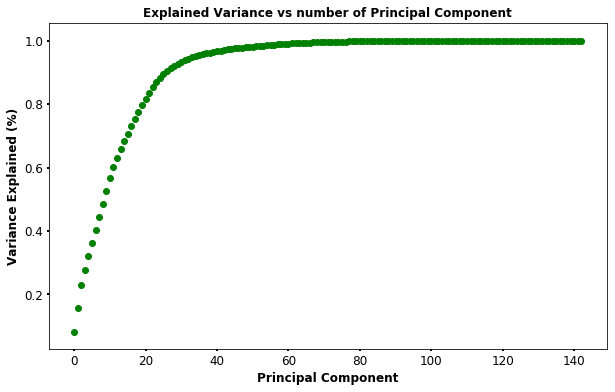

In [447]:
pca, X_train_pca_0 = PCAp(X_train_scaled, comp=None)

val = pca.explained_variance_ratio_

ind = np.arange(len(val))

val = val [:len(val)]
mp.figure(figsize=(10,6))
ax = mp.subplot(111)
    # Create array of cumulative variance explained for each n^th component
cumulative_values = np.cumsum(val)
    
# Plot line chart of cumulative variance explained vs number of components
ax.scatter(ind, cumulative_values, color = 'green')
ax.xaxis.set_tick_params(width=2, length=2, labelsize = '12')
ax.yaxis.set_tick_params(width=2, length=2, labelsize = '12')
ax.set_xlabel("Principal Component", fontsize = 12, weight = 'bold')
ax.set_ylabel("Variance Explained (%)", fontsize = 12, weight = 'bold')
mp.title('Explained Variance vs number of Principal Component', fontsize = 12, weight = 'bold')
    

##### Analysis:

As we can see that n = 50 is where we we level off, so we will use n = 50

In [444]:
comp = 50
pca, X_train_pca = PCAp(X_train_scaled, comp=comp)

X_train_pca.head()

,pca_comp_n_0,pca_comp_n_1,pca_comp_n_2,pca_comp_n_3,pca_comp_n_4,pca_comp_n_5,pca_comp_n_6,pca_comp_n_7,pca_comp_n_8,pca_comp_n_9,...,pca_comp_n_40,pca_comp_n_41,pca_comp_n_42,pca_comp_n_43,pca_comp_n_44,pca_comp_n_45,pca_comp_n_46,pca_comp_n_47,pca_comp_n_48,pca_comp_n_49
9646,-0.509344,-0.951373,-0.580238,1.020710,-0.300959,2.464071,0.353014,-0.366059,-0.939258,0.553651,...,0.017077,-0.070628,0.019898,-0.058043,0.193720,-0.061598,-0.157263,0.007424,-0.055416,-0.028658
14547,-1.258198,-0.915182,-0.061419,0.763391,-0.507346,-0.164672,-0.162779,-0.096461,-0.276524,-0.474680,...,-0.124815,0.056488,-0.001813,0.234015,-0.627971,-0.109596,-0.467263,0.152862,0.026296,0.157055
4973,-1.775535,-0.171676,0.976962,-0.715381,-0.944434,-4.677339,-0.032317,0.677379,0.978501,0.401555,...,-0.006045,-0.046707,0.033963,-0.153789,0.094743,0.053705,0.762827,0.180017,-0.822441,-0.758646
3722,3.265983,-1.717830,-0.705073,1.806632,-0.907858,-0.578321,3.441303,-1.177115,2.142271,0.618331,...,-0.520454,0.195811,0.137093,0.243066,0.500492,0.060469,-0.794271,-0.139503,0.675134,0.064485
15713,-1.160094,-0.387810,-0.555856,-0.586074,0.093442,2.604291,-1.167037,0.100559,-1.270385,0.408218,...,-0.005522,-0.049960,-0.021716,0.030784,-0.026311,-0.001204,0.236373,0.077349,0.010749,0.166532


In [448]:
pca, X_test_pca = PCAp(X_test_scaled, comp=comp)

In [462]:
X_pred = gen_predict.drop(columns = cols)
ss, X_pred_scaled = SS(X_pred)
pca, X_pred_pca = PCAp(X_pred_scaled, comp=comp)

### Now we will try to predict income first, as it will help us predict gender, we could predict gender first if there was parity in the gender pay scale, but as we know, different genders are not paid the same income for the same position, so we first we have to predict income, then income is also dependent on age, so we will predict age and income first and then using the features created in age, and income prediction we will predict gender

### Income prediction

In [463]:
y_train = train['income']
y_test = test['income']

In [469]:
def GridCSV(df1, df2):
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)
    params = {'max_depth': [7,8], 'min_child_weight': np.arange(10,510,10), 'n_estimators': [100,150]}
    xgb_income = xgb.XGBRegressor(learning_rate = 0.1,\
                              objective = 'reg:linear',\
                              seed = 42,\
                              gamma = 0.1,\
                              silent = True)
    income_mod = GridSearchCV(xgb_income, param_grid=params,\
                            scoring='neg_mean_squared_error', n_jobs=4,\
                            cv=skf.split(df1,df2),\
                            verbose=2)
    return income_mod

In [471]:
income_mod = GridCSV(X_train_pca,y_train)

income_mod.fit(X_train_pca, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 19.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 41.9min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 75.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 125.8min finished
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\sklearn.py:249: DeprecationWarning: The silent parameter is deprecated.Please use verbosity instead.silent is depreated
  'silent is depreated', DeprecationWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000002434BAE2830>,
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [7, 8], 'n_estimators': [100, 150], 'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500])},
       pre_dispatch=

In [475]:
test_test_pred = income_mod.predict(X_test_pca)
test_mse = mean_squared_error(y_test, test_test_pred)
test_rmse = np.sqrt(test_mse)

print(test_rmse)

26188.15787064251


In [476]:
income_mod.best_params_

{'max_depth': 8, 'min_child_weight': 100, 'n_estimators': 150}

In [478]:
income_model_save = "income_mod.pickle.dat"
pickle.dump(income_mod.best_estimator_, open(income_model_save, "wb"))

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='income_mod.pickle.dat'>
  from ipykernel import kernelapp as app


In [481]:
gen_predict['income'] = income_mod.predict(X_pred_pca)
gen_predict.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
0,118,20170212,None,49012.394531,2017-02-12,2017,2,12,6961,0.0,...,1.0,0.0,0.0,0.222222,0.0,0,0,1,0,2
2,118,20180712,None,47926.199219,2018-07-12,2018,7,12,3746,0.0,...,0.0,0.5,0.0,0.000000,0.0,0,0,1,0,2
4,118,20170804,None,56003.808594,2017-08-04,2017,8,4,10735,0.0,...,0.6,0.4,0.0,0.000000,0.0,0,0,1,0,2
6,118,20170925,None,45051.671875,2017-09-25,2017,9,25,9524,0.0,...,0.6,0.2,0.0,0.000000,0.0,0,0,1,0,2
7,118,20171002,None,54276.816406,2017-10-02,2017,10,2,6939,0.0,...,0.4,0.0,0.0,0.000000,0.0,0,0,1,0,2


###### Replotting the income distribution now 

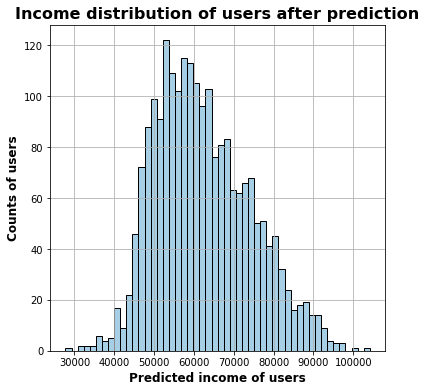

In [483]:
fig, ax = mp.subplots(figsize=(6,6));
gen_predict['income'].hist(bins=50, ax=ax,  color = a(0.35), edgecolor='black');
ax.set_title("Income distribution of users after prediction", fontsize=16, weight = 'bold')
ax.set_xlabel("Predicted income of users", fontsize=12, weight = 'bold');
ax.set_ylabel("Counts of users", fontsize=12, weight = 'bold');

##### Analysis:
    
    We can see that the income distribution is much more uniform. 
    
    
    

##### Predict Age


Now we will predict age

In [484]:
y_train = train['age']

y_test = test['age']

In [485]:
age_mod = GridCSV(X_train_pca,y_train)

age_mod.fit(X_train_pca, y_train)

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 19.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 41.8min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 74.4min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 114.2min finished
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\sklearn.py:249: DeprecationWarning: The silent parameter is deprecated.Please use verbosity instead.silent is depreated
  'silent is depreated', DeprecationWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000243701BF200>,
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [7, 8], 'n_estimators': [100, 150], 'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500])},
       pre_dispatch=

In [488]:
test_test_pred = age_mod.predict(X_test_pca)
test_mse = mean_squared_error(y_test, test_test_pred)
test_rmse = np.sqrt(test_mse)
print(test_rmse)

17.843638602690685


In [489]:
age_mod.best_params_

{'max_depth': 8, 'min_child_weight': 470, 'n_estimators': 100}

In [490]:
age_model_save = "age_mod.pickle.dat"
pickle.dump(age_mod.best_estimator_, open(age_model_save, "wb"))

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='age_mod.pickle.dat'>
  from ipykernel import kernelapp as app


In [493]:
gen_predict['age'] = age_mod.predict(X_pred_pca)
gen_predict.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
0,51.344147,20170212,None,49012.394531,2017-02-12,2017,2,12,6961,0.0,...,1.0,0.0,0.0,0.222222,0.0,0,0,1,0,2
2,52.185532,20180712,None,47926.199219,2018-07-12,2018,7,12,3746,0.0,...,0.0,0.5,0.0,0.000000,0.0,0,0,1,0,2
4,53.019188,20170804,None,56003.808594,2017-08-04,2017,8,4,10735,0.0,...,0.6,0.4,0.0,0.000000,0.0,0,0,1,0,2
6,50.638271,20170925,None,45051.671875,2017-09-25,2017,9,25,9524,0.0,...,0.6,0.2,0.0,0.000000,0.0,0,0,1,0,2
7,55.092476,20171002,None,54276.816406,2017-10-02,2017,10,2,6939,0.0,...,0.4,0.0,0.0,0.000000,0.0,0,0,1,0,2


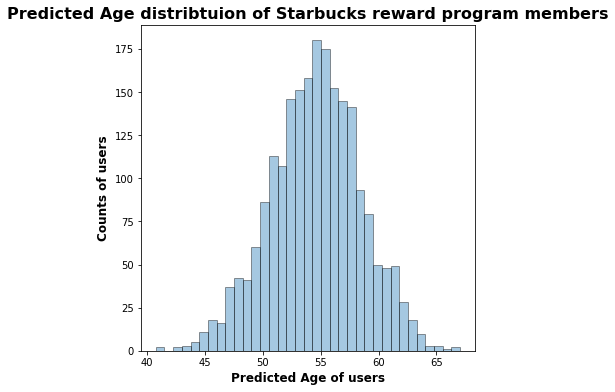

In [495]:
# Age distibution of users--it seems there are quite a few of 118 years old
fig, ax = mp.subplots(figsize=(6,6));
sns.distplot(gen_predict['age'], hist = True, kde = False, bins = 35,
                 hist_kws={'edgecolor':'black'},
                 label = 'Age distribution')
ax.set_title("Predicted Age distribtuion of Starbucks reward program members", fontsize=16, weight = 'bold')
ax.set_xlabel("Predicted Age of users", fontsize=12, weight = 'bold');
ax.set_ylabel("Counts of users", fontsize=12, weight = 'bold');

##### Analysis:
    
    We can see that the age distribution is much more uniform and no one is now 118 years old

##### Predict gender


In [497]:
y_train = train['gen_enc']

y_test = test['gen_enc']

In [498]:
gen_mod = GridCSV(X_train_pca,y_train)

gen_mod.fit(X_train_pca, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 19.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 47.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 87.8min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 134.2min finished
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\xgboost\sklearn.py:249: DeprecationWarning: The silent parameter is deprecated.Please use verbosity instead.silent is depreated
  'silent is depreated', DeprecationWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000002434BAE2FC0>,
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1, verbosity=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [7, 8], 'n_estimators': [100, 150], 'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500])},
       pre_dispatch=

In [503]:
test_test_pred = gen_mod.predict(X_test_pca)
gen_mod.best_params_

{'max_depth': 7, 'min_child_weight': 490, 'n_estimators': 100}

In [504]:
gen_model_save = "gen_mod.pickle.dat"
pickle.dump(gen_mod.best_estimator_, open(gen_model_save, "wb"))

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='gen_mod.pickle.dat'>
  from ipykernel import kernelapp as app


In [570]:
gen_predict['gen_enc'] = gen_mod.predict(X_pred_pca)
gen_predict.head()

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
0,51.344147,20170212,None,49012.394531,2017-02-12,2017,2,12,6961,0.0,...,1.0,0.0,0.0,0.222222,0.0,0,0,1,0,0.644409
2,52.185532,20180712,None,47926.199219,2018-07-12,2018,7,12,3746,0.0,...,0.0,0.5,0.0,0.000000,0.0,0,0,1,0,0.775303
4,53.019188,20170804,None,56003.808594,2017-08-04,2017,8,4,10735,0.0,...,0.6,0.4,0.0,0.000000,0.0,0,0,1,0,0.703310
6,50.638271,20170925,None,45051.671875,2017-09-25,2017,9,25,9524,0.0,...,0.6,0.2,0.0,0.000000,0.0,0,0,1,0,0.841151
7,55.092476,20171002,None,54276.816406,2017-10-02,2017,10,2,6939,0.0,...,0.4,0.0,0.0,0.000000,0.0,0,0,1,0,0.579037


In [601]:
len(gen_predict['gen_enc']) 

gen_predict['gen_enc']= gen_predict['gen_enc'].apply(lambda x:float(x))

gen_predict['gen_enc'] = round(gen_predict['gen_enc'])

gen_predict['gen_enc']= gen_predict['gen_enc'].apply(lambda x:int(x))



gen_predict['gender']=gencod.inverse_transform(gen_predict['gen_enc'])


#Ref: https://www.knowledgehut.com/blog/programming/python-rounding-numbers
#https://github.com/scikit-learn/scikit-learn/issues/3123
#https://firecharmca.wordpress.com/2018/03/22/feature-engineering-categorical-value-onehotencoder-and-why-not/
#https://stackoverflow.com/questions/53970350/valueerror-contains-new-labels-when-trying-to-label-encode-in-python

C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\TASLEEMAHMAD\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [603]:
gen_predict.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id,offer_id_0,...,frac_discount_n_offer,frac_info_n_offer,frac_bogo_n_trans,frac_discount_n_trans,frac_info_n_trans,gender_F,gender_M,gender_None,gender_O,gen_enc
0,51.344147,20170212,M,49012.394531,2017-02-12,2017,2,12,6961,0.0,...,1.0,0.0,0.0,0.222222,0.0,0,0,1,0,1
2,52.185532,20180712,M,47926.199219,2018-07-12,2018,7,12,3746,0.0,...,0.0,0.5,0.0,0.000000,0.0,0,0,1,0,1
4,53.019188,20170804,M,56003.808594,2017-08-04,2017,8,4,10735,0.0,...,0.6,0.4,0.0,0.000000,0.0,0,0,1,0,1
6,50.638271,20170925,M,45051.671875,2017-09-25,2017,9,25,9524,0.0,...,0.6,0.2,0.0,0.000000,0.0,0,0,1,0,1
7,55.092476,20171002,M,54276.816406,2017-10-02,2017,10,2,6939,0.0,...,0.4,0.0,0.0,0.000000,0.0,0,0,1,0,1


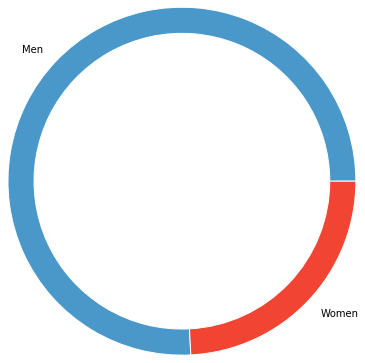

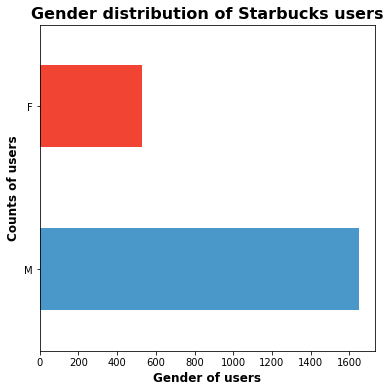

In [608]:
group_names=['Men', 'Women']
group_size=gen_predict['gender'].value_counts()

# Create colors
a, b, c=[mp.cm.Blues, mp.cm.Reds, mp.cm.Greens]
 
# First Ring 
fig, ax = mp.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=2.0, labels=group_names, colors=[a(0.6), b(0.6), c(0.6)] )
mp.setp( mypie, width=0.3, edgecolor='white')


fig, ax = mp.subplots(figsize=(6,6));
gen_predict['gender'].value_counts().plot(kind='barh', ax=ax, color=[a(0.6), b(0.6), c(0.6)]);
ax.set_title("Predicted Gender distribution of Starbucks users", fontsize=16, weight = 'bold')
ax.set_xlabel("Predicted Gender of users", fontsize=12,weight = 'bold');
ax.set_ylabel("Counts of users", fontsize=12,weight = 'bold');


##### Build New Profile

In [609]:
profile.head()

,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id
0,118,20170212,None,NaN,2017-02-12,2017,2,12,6961
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398
2,118,20180712,None,NaN,2018-07-12,2018,7,12,3746
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996
4,118,20170804,None,NaN,2017-08-04,2017,8,4,10735


In [626]:
profile['gender']= profile['gender'].apply(lambda x:str(x))


no_missing = profile[profile['gender'] != 'None']
missing = profile[profile['gender'] == 'None']

no_missing.head()


,age,became_member_on,gender,income,datetime,year_of_member,month_of_member,day_of_member,person_id
1,55,20170715,F,112000.0,2017-07-15,2017,7,15,398
3,75,20170509,F,100000.0,2017-05-09,2017,5,9,7996
5,68,20180426,M,70000.0,2018-04-26,2018,4,26,15043
8,65,20180209,M,53000.0,2018-02-09,2018,2,9,3728
12,58,20171111,M,51000.0,2017-11-11,2017,11,11,3059


In [628]:
missing = missing[['person_id', 'year_of_member', 'month_of_member', 'day_of_member']]

In [629]:
missing.head()

,person_id,year_of_member,month_of_member,day_of_member
0,6961,2017,2,12
2,3746,2018,7,12
4,10735,2017,8,4
6,9524,2017,9,25
7,6939,2017,10,2


In [630]:
gen_predict_summ = gen_predict[['age', 'gender', 'income', 'person_id']]
missing = pd.merge(missing, gen_predict_summ, on ='person_id', how = 'left')

missing = missing[['age', 'gender', 'income', 'person_id', 'year_of_member', 'month_of_member', 'day_of_member']]
missing.head()

,age,gender,income,person_id,year_of_member,month_of_member,day_of_member
0,51.344147,M,49012.394531,6961,2017,2,12
1,52.185532,M,47926.199219,3746,2018,7,12
2,53.019188,M,56003.808594,10735,2017,8,4
3,50.638271,M,45051.671875,9524,2017,9,25
4,55.092476,M,54276.816406,6939,2017,10,2


In [631]:
missing.shape

(2175, 7)

In [632]:
no_missing.shape

(14825, 9)

In [633]:
no_missing = no_missing[['age', 'gender', 'income', 'person_id', 'year_of_member', 'month_of_member', 'day_of_member']]

In [634]:
no_missing.head()

,age,gender,income,person_id,year_of_member,month_of_member,day_of_member
1,55,F,112000.0,398,2017,7,15
3,75,F,100000.0,7996,2017,5,9
5,68,M,70000.0,15043,2018,4,26
8,65,M,53000.0,3728,2018,2,9
12,58,M,51000.0,3059,2017,11,11


In [635]:
no_missing.shape

(14825, 7)

In [636]:
new_profile = pd.concat([no_missing, missing], axis = 0)
new_profile.head()

,age,gender,income,person_id,year_of_member,month_of_member,day_of_member
1,55.0,F,112000.0,398,2017,7,15
3,75.0,F,100000.0,7996,2017,5,9
5,68.0,M,70000.0,15043,2018,4,26
8,65.0,M,53000.0,3728,2018,2,9
12,58.0,M,51000.0,3059,2017,11,11


In [637]:
new_profile.shape

(17000, 7)

In [638]:
profile.shape

(17000, 9)

In [639]:
new_profile.to_csv("new_profile.csv", index = False)

In [648]:
new_profile2 = new_profile